# Homework 6

In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2023-10-18 13:21:26--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv’

housing.csv         100%[===================>]   1.36M  --.-KB/s    in 0.1s    

2023-10-18 13:21:27 (9.21 MB/s) - ‘housing.csv’ saved [1423529/1423529]



In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

%matplotlib inline

In [3]:
df = pd.read_csv('housing.csv')

In [4]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
df["ocean_proximity"].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [7]:
df_prep = df[(df["ocean_proximity"] == '<1H OCEAN') | (df["ocean_proximity"] == 'INLAND')]

In [8]:
df_prep.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [9]:
df_prep = df_prep.fillna(0)

In [10]:
df_prep.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [16]:
df_full_train, df_test = train_test_split(df_prep, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [17]:
y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

In [18]:
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [19]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

# Question 1

In [25]:
regressor = DecisionTreeRegressor(max_depth=1)
dt_model = regressor.fit(X_train, y_train)
y_pred = dt_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(rmse)

0.45168599736547216


[ 5 -2 -2]
The splitting feature at the root node is feature index ocean_proximity=<1H OCEAN.


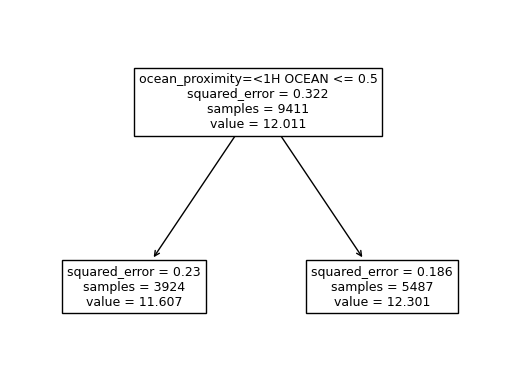

In [43]:
# Get the tree structure
tree = dt_model.tree_
print(tree.feature)
from sklearn.tree import plot_tree
plot_tree(dt_model, feature_names=list(dv.get_feature_names_out()))
# Find the splitting feature at the root node
root_splitting_feature = tree.feature[0]

# Print the index of the splitting feature
print(f"The splitting feature at the root node is feature index {list(dv.get_feature_names_out())[root_splitting_feature]}.")

In [26]:
print(export_text(dt_model, feature_names=list(dv.get_feature_names_out())))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



Looks like ocean_proximity

# Question 2

In [45]:
rf_model = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_val)
rmse = round(np.sqrt(mean_squared_error(y_val, y_pred)), 3)
print(rmse)

0.245


.245

# Question 3

In [46]:
def parameter_test(n_estimator):
    rf_model = RandomForestRegressor(n_estimators=n_estimator, random_state=1, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    return rmse

In [47]:
for i in range(10, 201, 10):
    print(f"n_estimator: {i} rmse: {round(parameter_test(i), 3)}" )

n_estimator: 10 rmse: 0.245
n_estimator: 20 rmse: 0.238
n_estimator: 30 rmse: 0.236
n_estimator: 40 rmse: 0.235
n_estimator: 50 rmse: 0.234
n_estimator: 60 rmse: 0.234
n_estimator: 70 rmse: 0.234
n_estimator: 80 rmse: 0.234
n_estimator: 90 rmse: 0.234
n_estimator: 100 rmse: 0.234
n_estimator: 110 rmse: 0.234
n_estimator: 120 rmse: 0.234
n_estimator: 130 rmse: 0.234
n_estimator: 140 rmse: 0.234
n_estimator: 150 rmse: 0.234
n_estimator: 160 rmse: 0.233
n_estimator: 170 rmse: 0.233
n_estimator: 180 rmse: 0.234
n_estimator: 190 rmse: 0.234
n_estimator: 200 rmse: 0.234


After n_estimator: 50 rmse: 0.234 rmse stops improving

# Question 4

In [48]:
def parameter_depth_test(n_estimator, max_depth):
    rf_model = RandomForestRegressor(n_estimators=n_estimator, max_depth=max_depth, random_state=1, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    return rmse

In [53]:
best_rmse = float("inf")
best_max_depth = float("inf")
for max_depth in [10, 15, 20, 25]:
    for n_est in range(10, 201, 10):
        rmse = round(parameter_depth_test(n_est, max_depth), 3)
        if rmse < best_rmse:
            best_rmse = rmse
            best_max_depth = max_depth
            print(f"max_depth: {max_depth} n_estimator: {n_est} rmse: {rmse}" )
print(f"Best rmse: {best_rmse} Best depth: {best_max_depth}")

max_depth: 10 n_estimator: 10 rmse: 0.251
max_depth: 10 n_estimator: 20 rmse: 0.247
max_depth: 10 n_estimator: 30 rmse: 0.246
max_depth: 10 n_estimator: 40 rmse: 0.245
max_depth: 10 n_estimator: 160 rmse: 0.244
max_depth: 15 n_estimator: 20 rmse: 0.239
max_depth: 15 n_estimator: 30 rmse: 0.237
max_depth: 15 n_estimator: 40 rmse: 0.236
max_depth: 15 n_estimator: 70 rmse: 0.235
max_depth: 15 n_estimator: 150 rmse: 0.234
max_depth: 20 n_estimator: 150 rmse: 0.233
Best rmse: 0.233 Best depth: 20


Looks like best rmse .233 at a max_depth of 20

# Question 5

In [55]:
rf_model = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_val)
rmse = round(np.sqrt(mean_squared_error(y_val, y_pred)), 3)
print(rmse)

0.245


In [62]:
feature_importances = zip(rf_model.feature_importances_, list(dv.get_feature_names_out()))
for importance, name in sorted(feature_importances, reverse=True):
    print(f"Name: {name} Importance: {importance}")

Name: median_income Importance: 0.3355070433470429
Name: ocean_proximity=<1H OCEAN Importance: 0.21881985433078338
Name: ocean_proximity=INLAND Importance: 0.1474595540682817
Name: latitude Importance: 0.10271687386164392
Name: longitude Importance: 0.08579061141056853
Name: housing_median_age Importance: 0.03004269417873657
Name: population Importance: 0.02821150531672544
Name: total_rooms Importance: 0.02131944133831403
Name: total_bedrooms Importance: 0.015227641883313336
Name: households Importance: 0.014904780264590167


median income appears to be the most important feature

# Question 6

In [71]:
features = list(dv.get_feature_names_out())
features = [feature.replace('=<', '_').replace('=', '_') for feature in features]

In [72]:
# features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [73]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [86]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [87]:

xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)

[0]	train-rmse:8.07362	val-rmse:8.07348
[1]	train-rmse:5.65832	val-rmse:5.65617
[2]	train-rmse:3.96917	val-rmse:3.96541
[3]	train-rmse:2.78836	val-rmse:2.78530
[4]	train-rmse:1.96409	val-rmse:1.96088
[5]	train-rmse:1.38983	val-rmse:1.38852
[6]	train-rmse:0.99273	val-rmse:0.99253
[7]	train-rmse:0.71854	val-rmse:0.72138
[8]	train-rmse:0.53440	val-rmse:0.54054
[9]	train-rmse:0.41016	val-rmse:0.42108
[10]	train-rmse:0.33195	val-rmse:0.34802
[11]	train-rmse:0.28413	val-rmse:0.30539
[12]	train-rmse:0.25487	val-rmse:0.28044
[13]	train-rmse:0.23748	val-rmse:0.26681
[14]	train-rmse:0.22789	val-rmse:0.25955
[15]	train-rmse:0.22197	val-rmse:0.25614
[16]	train-rmse:0.21543	val-rmse:0.25268
[17]	train-rmse:0.21034	val-rmse:0.24871
[18]	train-rmse:0.20688	val-rmse:0.24786
[19]	train-rmse:0.20341	val-rmse:0.24612
[20]	train-rmse:0.20036	val-rmse:0.24508
[21]	train-rmse:0.19827	val-rmse:0.24376
[22]	train-rmse:0.19644	val-rmse:0.24257
[23]	train-rmse:0.19320	val-rmse:0.24095
[24]	train-rmse:0.19203	va

In [85]:
y_pred = xgb_model.predict(dval)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"Root Mean Squared Error (RMSE): {round(rmse, 3)}")

Root Mean Squared Error (RMSE): 0.229


.3 Root Mean Squared Error (RMSE): 0.229

.1 Root Mean Squared Error (RMSE): 0.232

.3 appears better